Code retrieved from [DCC_O3_aniso](https://dcc.ligo.org/LIGO-G2002165/public) (SpH: credits to Erik Floden and Leo Tsukasa; BBR: my own code used during O3)

In [1]:
import numpy as np
import healpy as hp
import h5py
import scipy.io as sio
import matplotlib # requires matplotlib version >= 3.2.2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.io import loadmat
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
fontsize = 24
matplotlib.rcParams.update({
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize*0.9,
    "xtick.labelsize": fontsize*0.9,
    "ytick.labelsize": fontsize*0.9,
    "xtick.major.size": fontsize * 0.5,
    "ytick.major.size": fontsize * 0.5,
    "legend.fontsize": fontsize * 0.9,
    "font.family": "Times new Roman",
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "text.usetex": True,
    "path.simplify": True,
    "figure.figsize": (8, 6)
})

# Class to deal in an easy way with number of digits in colorbars (used for ULs and sigma maps)
# It allows to choose the number of digits for tickslabels and keeping 10^N at the right of the colorbar
# instead of having 1eN for each tickslabel.

class FormatScalarFormatter(matplotlib.ticker.ScalarFormatter):
            def __init__(self, fformat="%1.1f", offset=True, mathText=True):
                self.fformat = fformat
                matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,
                                                        useMathText=mathText)
            def _set_format(self):
                self.format = self.fformat
                if self._useMathText:
                    #self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)
                    self.format = '$%s$' % ('\\mathdefault{%s}' % self.format)


In [3]:
# variable corresponding to spectral shapes of signal models 
alphas = ["0", "2over3", "3"]
fig_dir = "./Figures/"

findfont: Font family ['Times new Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times new Roman'] not found. Falling back to DejaVu Sans.


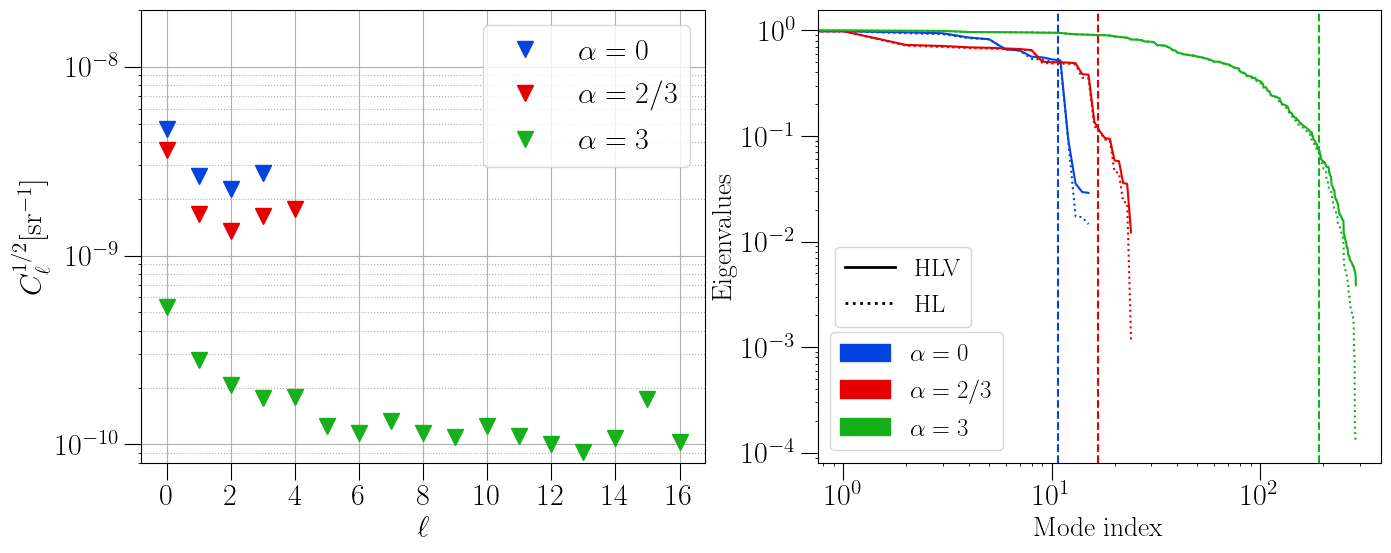

In [4]:
H0 = 2.2005e-18 # Hubble constant 
fref = 25.0 # reference frequency
const = 2.0 * np.pi**2 * fref**3 / (3 * H0**2) # normalization constant

colors = ['xkcd:blue', 'xkcd:red', 'xkcd:green']
fig, axs= plt.subplots(figsize = (16,6), nrows=1, ncols=2)
ax = axs[0]

# Loop over the upper limit *.mat files for the three spectral indices 0, 2/3 and 3
for alpha, color in zip(alphas, colors):
    pproc_file = "./SHD_data/shd_ul_a" + alpha + "_o1_o2_o3_rerun20210424_shd_map_files.mat"
    shd_data = loadmat(pproc_file)
    lmax = shd_data['L']
    Cell_ul = shd_data["omega_cl_ul"]
    Cell = shd_data['omega_cl']
    ax.semilogy(np.arange(lmax + 1), np.sqrt(Cell_ul)[0], color=color, linestyle="None", marker="v", markersize = 12, label=r"$\alpha=%s$" % alpha.replace("over", "/"))

ax.grid(which="major", linestyle="-")
ax.grid(which="minor", linestyle=":")
ax.legend(loc="upper right")
ax.set_xticks(np.arange(0, 17, 2))
ax.set_yticks([1e-8, 1e-9, 1e-10])
ax.set_ylim((0.8e-10, 0.2e-7))
ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^{1/2}[\mathrm{sr}^{-1}]$")


baselines = ["HL", "HLV"]
colors = ['xkcd:blue', 'xkcd:red', 'xkcd:green']
fkeep = 2/3 # keep 2/3 of dominant eigen values
yvals = []

ax = axs[1]

# Loop over the *.mat files for the three spectral indices 0, 2/3 and 3; for HL and HLV network
for i, (alpha, color) in enumerate(zip(alphas, colors)):    
    for ii, (baseline, style) in enumerate(zip(baselines, ["dotted", "solid"])):
        matfile = "./SHD_data/shd_ul_a" + alpha + "_rerun20210424_shd_map_files_" + baseline + ".mat"
        Fisher = loadmat(matfile)["fisher0"]
        eigs, _ = np.linalg.eigh(Fisher) # calculate eigen values
        eigs = eigs[::-1]
        yvals.append(eigs/eigs[0])
        if alpha == '2over3':
            lab = r'$\alpha=2/3$' + ', ' + baseline
        else:   
            lab = r'$\alpha=$%s'%alpha + ', ' + baseline
        ax.loglog(np.arange(len(eigs)), eigs/eigs[0], color=color, linestyle=style, label=lab)
    ax.axvline(len(eigs) * fkeep, linestyle="--", color=color)
_, _ = ax.get_legend_handles_labels()
legend_elements1 = [mpatches.Patch(color=color, label=r"$\alpha=%s$" % alpha.replace("over", "/")) for color, alpha in zip(colors, alphas)]
legend_elements2 = [Line2D([0], [0], color="k", lw=2, label=label, linestyle=ls) for ls, label in zip(["-", ":"], ["HLV", "HL"])]
leg1 = ax.legend(handles=legend_elements1, loc='lower left', frameon=True, fontsize=18)
leg2 = ax.legend(handles=legend_elements2, loc=(0.03, 0.3), frameon=True, fontsize=18)
ax.add_artist(leg1)
for line in leg2.get_lines():
    line.set_linewidth(2)
ax.set_xlabel("Mode index",fontsize=20)
ax.set_ylabel("Eigenvalues",fontsize=20)
#plt.savefig(fig_dir + "shd_fisher_plot_rerun20210424.pdf", bbox_inches='tight')

plt.savefig(fig_dir + "O3_SpH.pdf", bbox_inches='tight')


plt.show()

## BBR

In [5]:
#some variables used in path definitions
alphas = ["0", "23", "3"]
alphas_ul =["0", "2", "3"]
zero_lag_path = "./BBR_data/"

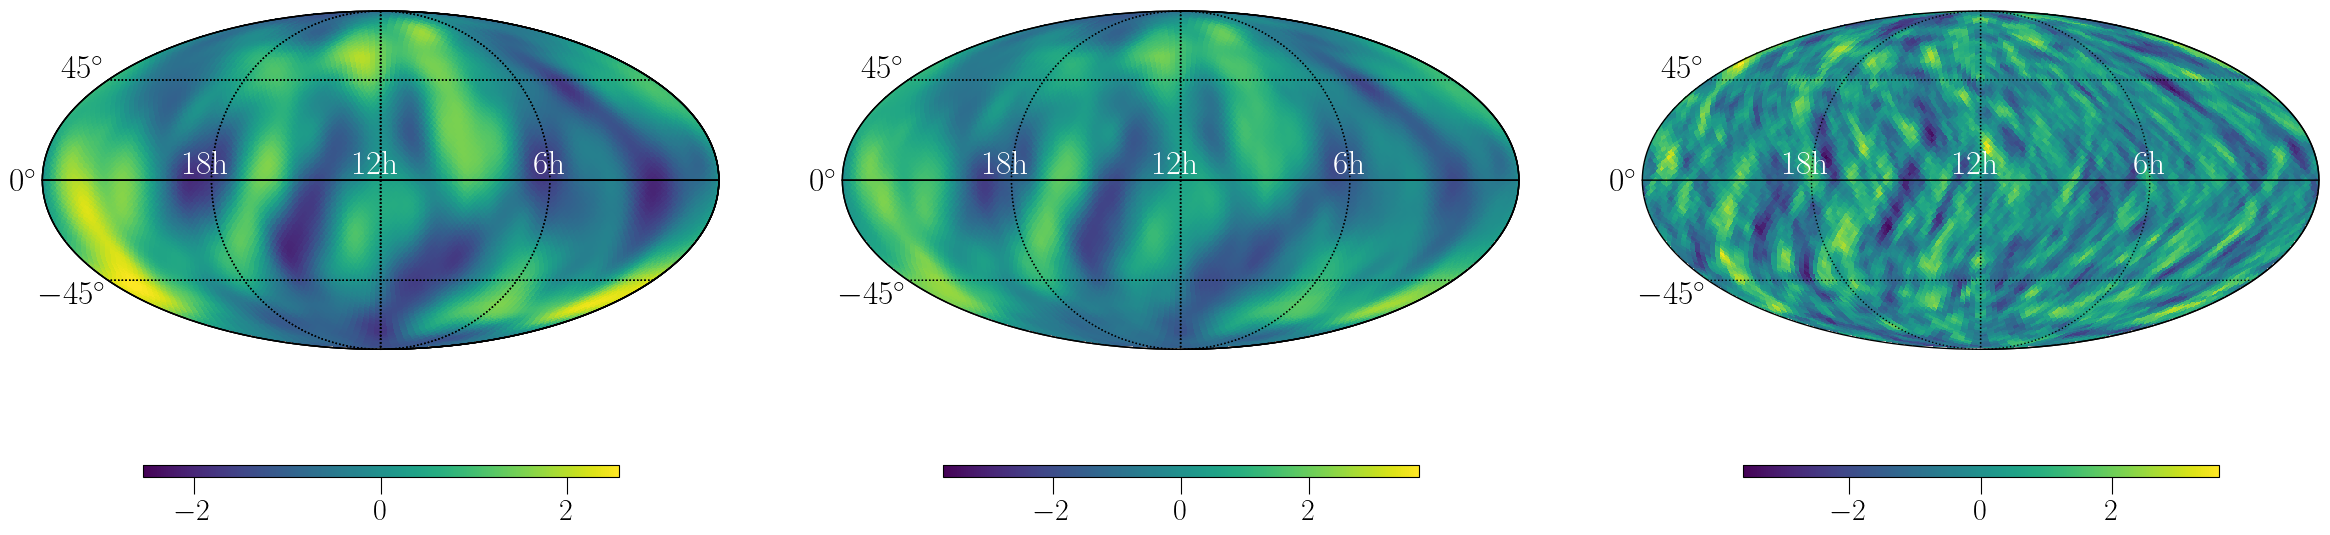

In [6]:
#Figure 2 (Upper row)
#SNR sky-maps for BBR analysis

#Create figure
fig = plt.figure(figsize=(24, 8))

#Limits for the colorbars
vlims = [2.55, 3.72, 3.63]


#Loop over the *combined_maps.hdf5 files for the three spectral indices 0, 2/3 and 3
for alpha, vlim, index in zip (alphas, vlims, range(0,len(alphas))):
    
    #Directory of the .hdf5 file
    snr_dir = zero_lag_path + "/a" + alpha + "_o1_o2_o3_combined_maps.hdf5"
    
    #Read the file and create a dictionary-like variable
    combined_snr = h5py.File(snr_dir, "r")

    #Select the map of interest (SNR map)
    snr_map = np.array(combined_snr["map_snr_total"])
    
    #Close the file
    combined_snr.close()
    
    #Plot the sky-map for a given alpha as subplot using healpy Mollweide projection
    hp.mollview(np.real(np.squeeze(snr_map)),rot=(180,0,0),flip='astro', title="",nest=False, format = "%.2f", cbar=False, sub=(1, 3, index+1), margins=[0.0125,0.0125, 0.0125, 0.0125], min=-vlim, max=vlim)
    
    #Add graticule
    hp.graticule(45,90)
    
    #Add useful annotations on the map for right ascension and declination
    plt.annotate('12h',(0.46,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('6h',(0.725,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('18h',(0.21,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate(r'$45^{\circ}$',(0.03,0.8),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$0^{\circ}$',(-0.045,0.47),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$-45^{\circ}$',(-0.002,0.14),xycoords='axes fraction', fontsize=fontsize) 
    
    #Trick to make colorbars all the same (healpy colorbar does not leave much freedom of customization and it is not used)
    fig = plt.gcf()
    ax = plt.gca()  
    image = ax.get_images()[0]
    cmap = fig.colorbar(image, ax=ax, shrink=0.7, orientation="horizontal", pad=0.15, aspect = 40, ticks=[-2,0,2])
    
#Save the figure    
#plt.savefig("./BBR_o1_o2_o3_combined_SNR_maps_all_together_multi.png", dpi=300, bbox_inches='tight')
plt.savefig("./Figures/BBR_o1_o2_o3_combined_SNR_maps_all_together_multi.pdf", bbox_inches='tight')

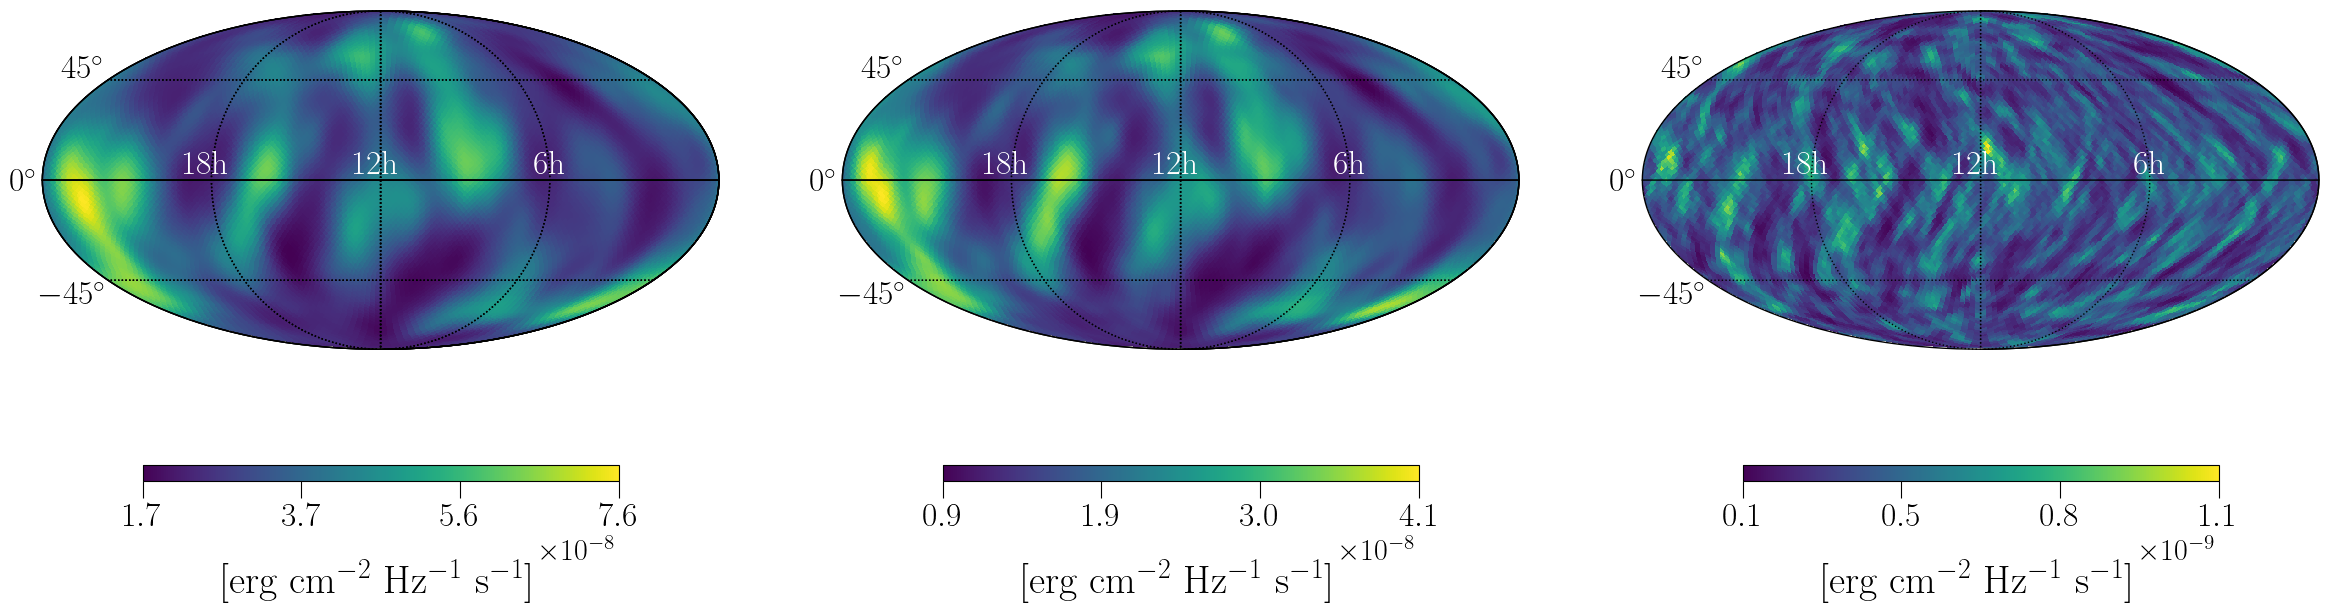

In [7]:
#Figure 2 (lower row)
#ULs sky-maps for BBR analysis

#The same procedure as for the SNR maps, but reading .mat files

fig = plt.figure(figsize=(24, 8))
for alpha, alpha_u, index in zip (alphas, alphas_ul, range(0,len(alphas))):
    
    ul_dir = zero_lag_path + "/bbr_a"+ alpha_u +"_zl_limits.mat"
    
    combined_ul = sio.loadmat(ul_dir)
    ul_map = np.squeeze(np.array(combined_ul["flux_ul_combined"]))
    
    hp.mollview(np.real(np.squeeze(ul_map)),rot=(180,0,0),flip='astro', title="",nest=False, format = "%.2g", cbar=False, sub=(1, 3, index+1), margins=[0.0125,0.0125, 0.0125, 0.0125])
    hp.graticule(45,90)
    plt.annotate('12h',(0.46,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('6h',(0.725,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('18h',(0.21,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate(r'$45^{\circ}$',(0.03,0.8),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$0^{\circ}$',(-0.045,0.47),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$-45^{\circ}$',(-0.002,0.14),xycoords='axes fraction', fontsize=fontsize) 
    
    
    fig = plt.gcf()
    ax = plt.gca()  
    image = ax.get_images()[0]
    
    #Further colorbar customization
    nticks = 4
    interval = 1./(nticks-1)
    diff= np.max(ul_map) -np.min(ul_map)
    ticks_no_round = [np.min(ul_map)+(diff)*interval*x for x in np.arange(0,nticks)]
    
    cmap = fig.colorbar(image, ax=ax, ticks=ticks_no_round, format=FormatScalarFormatter("%.1f"), shrink=0.7, orientation="horizontal", pad=0.15, aspect = 30)
    
    # Adding units as colorbar label
    cmap.set_label(r'[erg cm$^{-2}$ Hz$^{-1}$ s$^{-1}$]', fontsize = 1.2*fontsize, labelpad = 20)
    #ax.text(0.23, -0.695, r'[erg cm$^{-2}$ Hz$^{-1}$ s$^{-1}$]', fontsize=fontsize, transform=ax.transAxes)
    cmap.ax.tick_params(labelsize=fontsize)
    
#plt.savefig("./BBR_UL_combined_all_together_multi.png", dpi=300, bbox_inches='tight')
plt.savefig("./Figures/BBR_UL_combined_all_together_multi.pdf", bbox_inches='tight')

## Alternative style

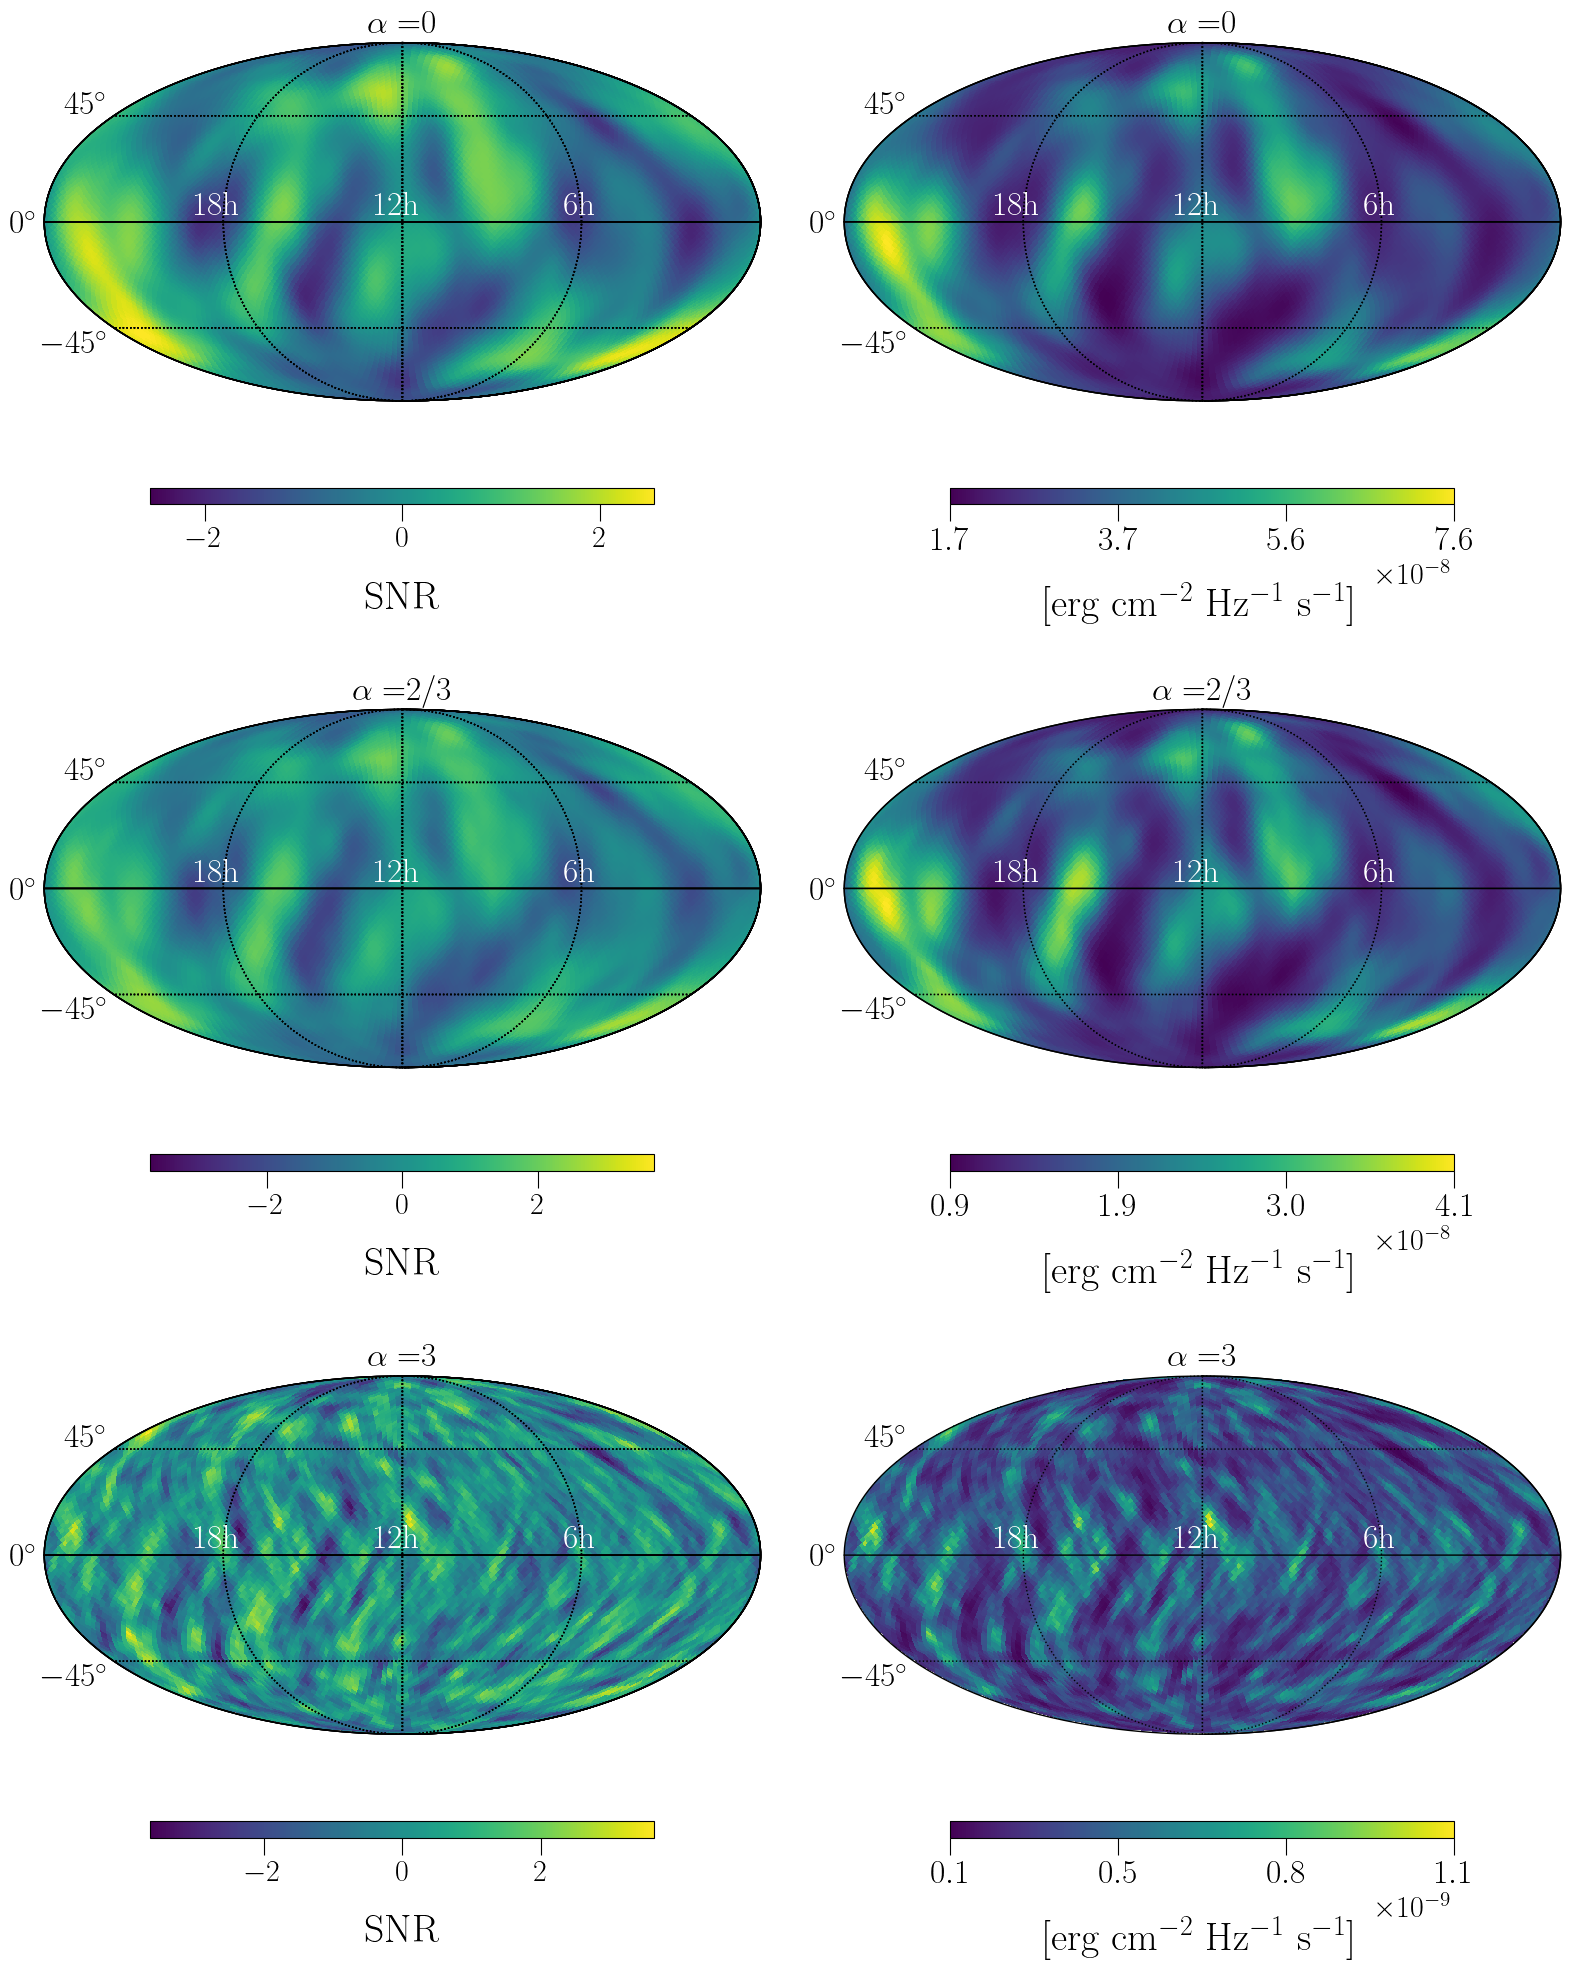

In [8]:
#Create figure
fig = plt.figure(figsize=(16, 20))

#Limits for the colorbars
vlims = [2.55, 3.72, 3.63]


#Loop over the *combined_maps.hdf5 files for the three spectral indices 0, 2/3 and 3
for alpha, vlim, index in zip (alphas, vlims, range(0,len(alphas))):
    
    #Directory of the .hdf5 file
    snr_dir = zero_lag_path + "/a" + alpha + "_o1_o2_o3_combined_maps.hdf5"
    
    #Read the file and create a dictionary-like variable
    combined_snr = h5py.File(snr_dir, "r")

    #Select the map of interest (SNR map)
    snr_map = np.array(combined_snr["map_snr_total"])
    
    #Close the file
    combined_snr.close()
    
    #Plot the sky-map for a given alpha as subplot using healpy Mollweide projection
    hp.mollview(np.real(np.squeeze(snr_map)),rot=(180,0,0),flip='astro', title=r"$\alpha =$"+f"{alpha}".replace("23", "2/3"),nest=False, format = "%.2f", cbar=False, sub=(3, 2, 2*index+1), margins=[0.0125,0.0125, 0.0125, 0.0125], min=-vlim, max=vlim)
    
    #Add graticule
    hp.graticule(45,90)
    
    #Add useful annotations on the map for right ascension and declination
    plt.annotate('12h',(0.46,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('6h',(0.725,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('18h',(0.21,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate(r'$45^{\circ}$',(0.03,0.8),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$0^{\circ}$',(-0.045,0.47),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$-45^{\circ}$',(-0.002,0.14),xycoords='axes fraction', fontsize=fontsize) 
    
    #Trick to make colorbars all the same (healpy colorbar does not leave much freedom of customization and it is not used)
    fig = plt.gcf()
    ax = plt.gca()  
    image = ax.get_images()[0]
    cmap = fig.colorbar(image, ax=ax, shrink=0.7, orientation="horizontal", pad=0.15, aspect = 30, ticks=[-2,0,2])
    cmap.set_label("SNR", fontsize = 1.2*fontsize, labelpad = 20)
    
for alpha, alpha_u, index in zip (alphas, alphas_ul, range(0,len(alphas))):
    
    ul_dir = zero_lag_path + "/bbr_a"+ alpha_u +"_zl_limits.mat"
    
    combined_ul = sio.loadmat(ul_dir)
    ul_map = np.squeeze(np.array(combined_ul["flux_ul_combined"]))
    
    hp.mollview(np.real(np.squeeze(ul_map)),rot=(180,0,0),flip='astro', title=r"$\alpha =$"+f"{alpha}".replace("23", "2/3"),nest=False, format = "%.2g", cbar=False, sub=(3, 2, 2*index+2), margins=[0.0125,0.0125, 0.0125, 0.0125])
    hp.graticule(45,90)
    plt.annotate('12h',(0.46,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('6h',(0.725,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate('18h',(0.21,0.52),xycoords='axes fraction', color='w', fontsize=fontsize)
    plt.annotate(r'$45^{\circ}$',(0.03,0.8),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$0^{\circ}$',(-0.045,0.47),xycoords='axes fraction', fontsize=fontsize)
    plt.annotate(r'$-45^{\circ}$',(-0.002,0.14),xycoords='axes fraction', fontsize=fontsize) 
    
    
    fig = plt.gcf()
    ax = plt.gca()  
    image = ax.get_images()[0]
    
    #Further colorbar customization
    nticks = 4
    interval = 1./(nticks-1)
    diff= np.max(ul_map) -np.min(ul_map)
    ticks_no_round = [np.min(ul_map)+(diff)*interval*x for x in np.arange(0,nticks)]
    
    cmap = fig.colorbar(image, ax=ax, ticks=ticks_no_round, format=FormatScalarFormatter("%.1f"), shrink=0.7, orientation="horizontal", pad=0.15, aspect = 30)
    
    # Adding units as colorbar label
    cmap.set_label(r'[erg cm$^{-2}$ Hz$^{-1}$ s$^{-1}$]', fontsize = 1.2*fontsize, labelpad = 20)
    #ax.text(0.23, -0.695, r'[erg cm$^{-2}$ Hz$^{-1}$ s$^{-1}$]', fontsize=fontsize, transform=ax.transAxes)
    cmap.ax.tick_params(labelsize=fontsize)    

plt.savefig("./Figures/BBR_O3_alternative_style.pdf", bbox_inches = "tight")
plt.show()   